# Lectura y Análisis

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Missing values
from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator

## Carga de datos

### Lectura de ficheros

Se leen los distintos fichero con la información meteorlógica.

Se establece una cota temporal a los datos de todos los ficheros.

In [86]:
dataframes = {}

def load(file, directory, start_date=None, end_date=None):
    file_path = directory + file
    file_key = file.replace(".csv", "")  # Remove .csv extension for index
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        df = df.sort_index()
        df_hourly = df.resample('h').mean()  # Resample by hour
        
        # Apply date filtering if start_date and end_date are provided
        if start_date and end_date:
            df_hourly = df_hourly.loc[start_date:end_date]
        
        dataframes[file_key] = df_hourly
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [87]:
# Read the CSV files
directory = "data/"
cuesta_openmetoe_arpege = "openmeteo_cuesta_arpege.csv"
cuesta_openmetoe_icon = "openmeteo_cuesta_icon.csv"

cuesta_grafcan = "grafcan_cuesta.csv"

#########
# Dates #
#########
start_date = "2023-03-01"
end_date = "2025-02-28"

data_files = [cuesta_openmetoe_arpege,
              cuesta_openmetoe_icon,
              cuesta_grafcan]
for file in data_files:
    load(file, directory, start_date, end_date)


Processing openmeteo_cuesta_arpege.csv...
Processing openmeteo_cuesta_icon.csv...
Processing grafcan_cuesta.csv...


## Visualización

In [88]:
def plot_datasets(datasets, column):
    """
    Plot a specific column from each dataset (given as a list of filenames)
    for all common years.
    
    Parameters:
        datasets (list): List of dataset filenames (e.g., ['file1.csv', 'file2.csv', ...]).
        column (str): The column name to plot from each dataset.
    """
    # Remove .csv extension if present and check if each dataset is loaded
    dataset_names = [name.replace(".csv", "") for name in datasets]
    for name in dataset_names:
        if name not in dataframes:
            print(f"Dataset '{name}' is not loaded.")
            return

    # Retrieve the dataframes
    dfs = [dataframes[name] for name in dataset_names]

    # Align all dataframes on their timestamps by concatenating on axis=1 (inner join ensures common timestamps)
    # Using keys creates a hierarchical column index: top level is dataset name, lower level is the original columns.
    combined = pd.concat(dfs, axis=1, join='inner', keys=dataset_names)
    
    # Ensure the indicated column exists in every dataset
    for name in dataset_names:
        if column not in combined[name].columns:
            print(f"Column '{column}' not found in dataset '{name}'.")
            return

    # Get all common years from the combined index
    common_years = combined.index.year.unique()
    
    # Plot the indicated column for each dataset by year
    for year in common_years:
        df_year = combined[combined.index.year == year]
        plt.figure(figsize=(10, 6))
        for name in dataset_names:
            plt.plot(df_year.index, df_year[name][column],
                     label=f"{name}", linestyle='-', alpha=0.7)
        plt.title(f'Comparison Plot - Column "{column}" - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()


### OpenMeteo

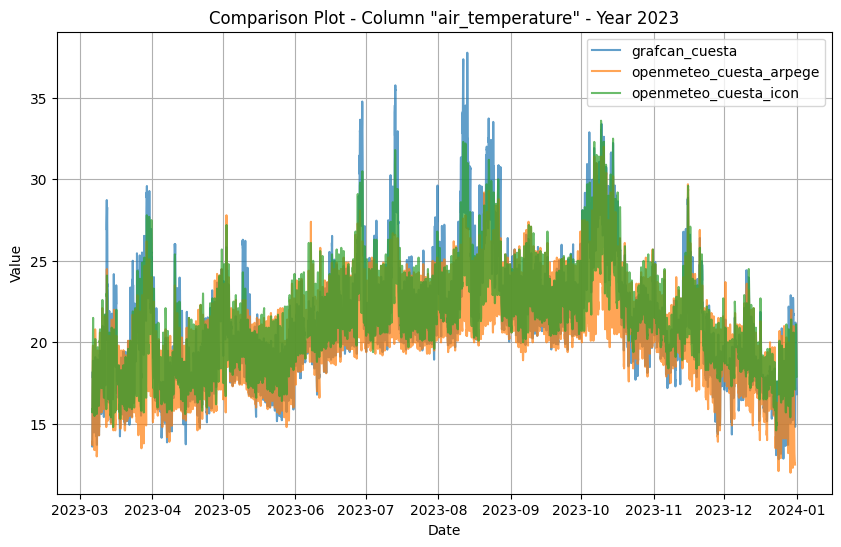

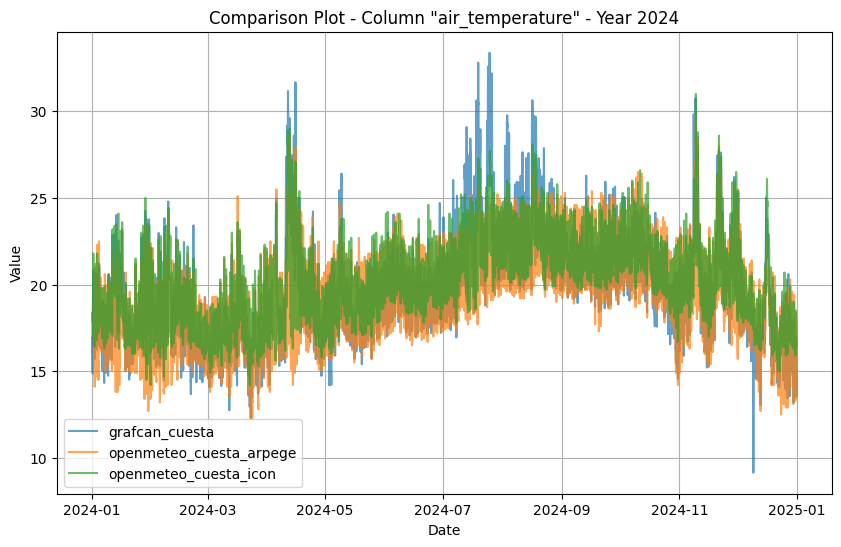

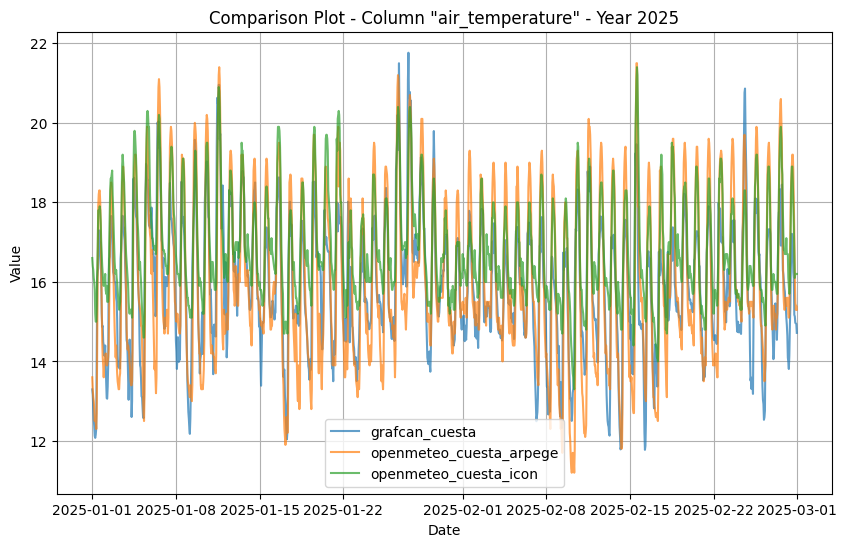

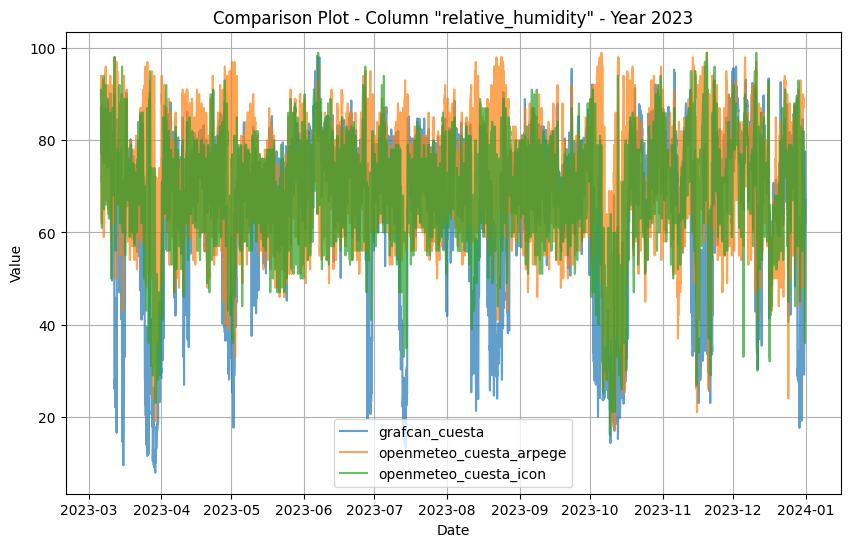

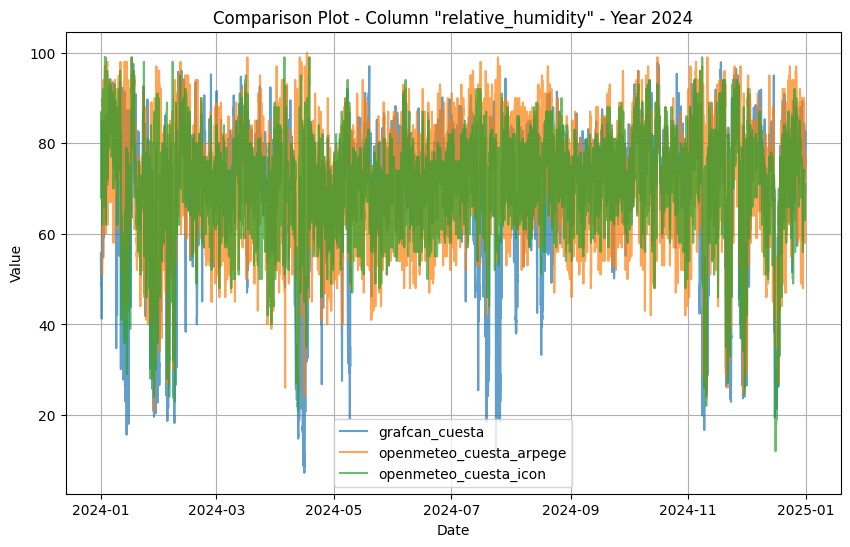

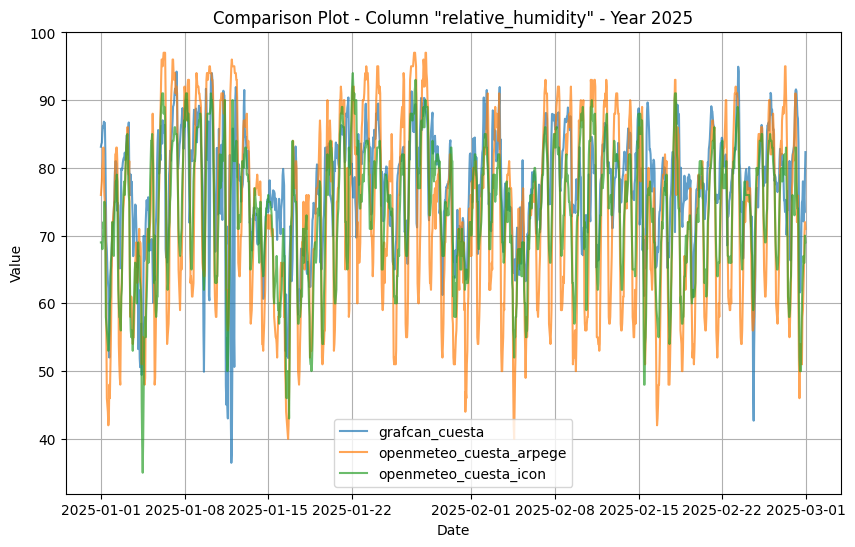

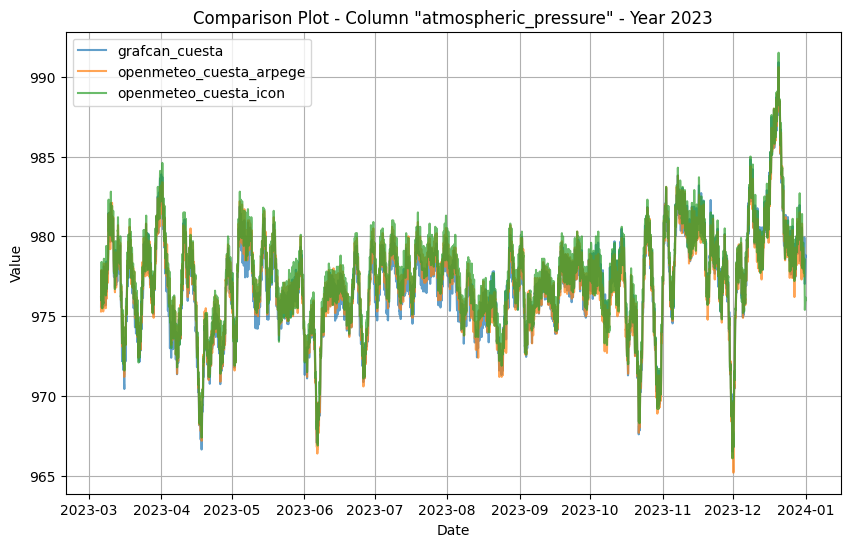

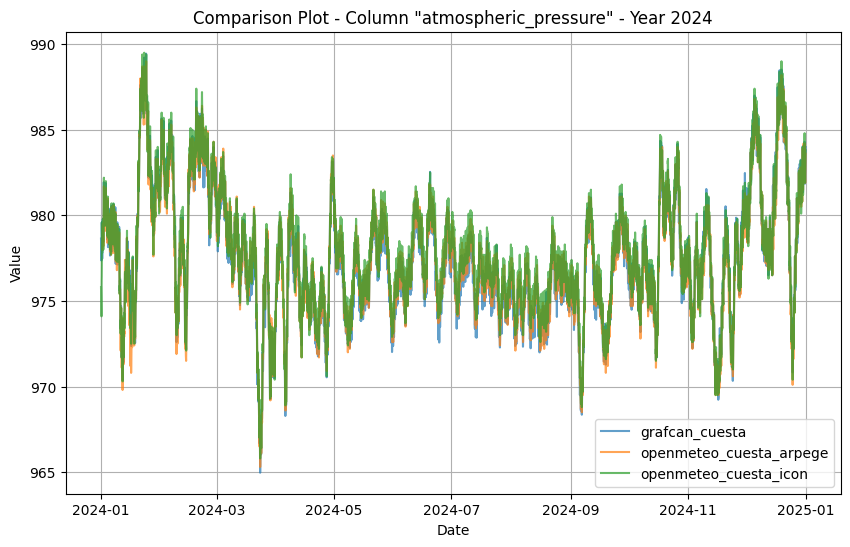

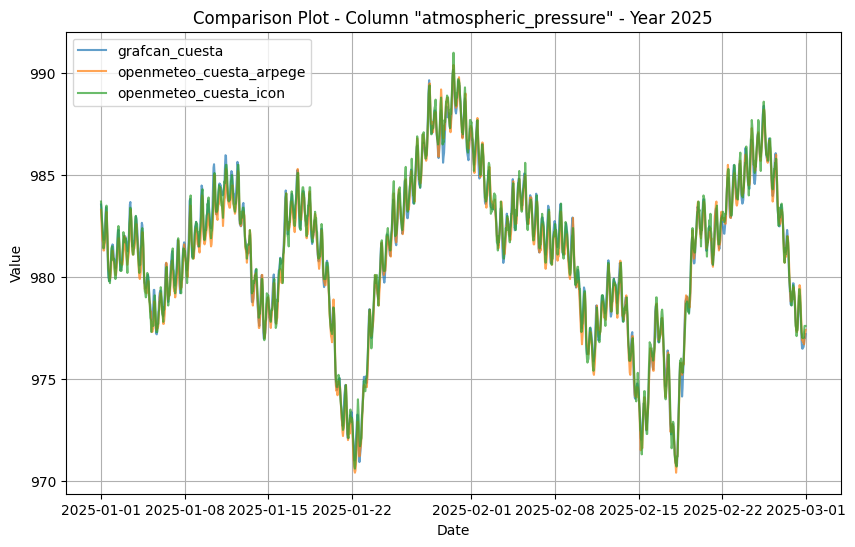

In [89]:
plot_datasets([cuesta_grafcan, cuesta_openmetoe_arpege, cuesta_openmetoe_icon], "air_temperature")
plot_datasets([cuesta_grafcan, cuesta_openmetoe_arpege, cuesta_openmetoe_icon], "relative_humidity")
plot_datasets([cuesta_grafcan, cuesta_openmetoe_arpege, cuesta_openmetoe_icon], "atmospheric_pressure")

## Horas faltantes

In [90]:
    
for file_key, df_hourly in dataframes.items():
    # Check for missing hours in the time series
    # Detect missing hours after resampling
    missing_hours = df_hourly[df_hourly.isna().any(axis=1)].index

    # Print missing hours if any
    if len(missing_hours) > 0:
        print(f"Missing hours in {file_key} after resampling:")
        print(missing_hours.tolist())
        print(len(missing_hours))
    else:
        print(f"No missing hours in {file_key} after resampling.")

Missing hours in openmeteo_cuesta_arpege after resampling:
[Timestamp('2023-12-31 07:00:00+0000', tz='UTC'), Timestamp('2023-12-31 08:00:00+0000', tz='UTC'), Timestamp('2023-12-31 09:00:00+0000', tz='UTC'), Timestamp('2023-12-31 10:00:00+0000', tz='UTC'), Timestamp('2023-12-31 11:00:00+0000', tz='UTC'), Timestamp('2023-12-31 12:00:00+0000', tz='UTC'), Timestamp('2023-12-31 13:00:00+0000', tz='UTC'), Timestamp('2023-12-31 14:00:00+0000', tz='UTC'), Timestamp('2023-12-31 15:00:00+0000', tz='UTC'), Timestamp('2023-12-31 16:00:00+0000', tz='UTC'), Timestamp('2023-12-31 17:00:00+0000', tz='UTC'), Timestamp('2023-12-31 18:00:00+0000', tz='UTC'), Timestamp('2023-12-31 19:00:00+0000', tz='UTC'), Timestamp('2023-12-31 20:00:00+0000', tz='UTC'), Timestamp('2023-12-31 21:00:00+0000', tz='UTC'), Timestamp('2023-12-31 22:00:00+0000', tz='UTC'), Timestamp('2023-12-31 23:00:00+0000', tz='UTC'), Timestamp('2024-01-01 00:00:00+0000', tz='UTC'), Timestamp('2024-01-01 01:00:00+0000', tz='UTC'), Timestamp

### Manejo Horas faltantes

In [91]:
# Cubic Spline Interpolation Algorithm

def cubic_spline_interpolation(df):
 # Convert datetime index to a numeric format (Unix timestamp in seconds)
    numeric_index = df.index.astype(np.int64) // 10**9

    # Iterate over each feature column and apply cubic spline interpolation
    for col in df.columns:
        valid_mask = ~df[col].isna()
        # Check if there are enough valid points for interpolation
        if valid_mask.sum() >= 2:

            pchip = PchipInterpolator(numeric_index[valid_mask], df.loc[valid_mask, col])
            interpolated_values = pchip(numeric_index)

            #cs = CubicSpline(numeric_index[valid_mask], df.loc[valid_mask, col], bc_type='natural')
            #interpolated_values = cs(numeric_index)
            df[col] = df[col].fillna(pd.Series(interpolated_values, index=df.index))
        else:
            print(f"Not enough data points to interpolate column '{col}'.")
            
    return df

In [92]:
for file_key, df_hourly in dataframes.items():
    # Perform cubic spline interpolation on the dataframe
    cubic_spline_interpolation(df_hourly)

## Comparativa datasets predicciones

In [93]:
def datasets_similarity(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1]
    df2 = dataframes[file2]
    df1, df2 = df1.align(df2, join='inner')
    
    similarity_results = {}
    for column in df1.columns:
        if column in df2.columns:
            try:
                pearson_corr, _ = pearsonr(df1[column], df2[column])
                spearman_corr, _ = spearmanr(df1[column], df2[column])
                kendall_corr, _ = kendalltau(df1[column], df2[column])
                mse = mean_squared_error(df1[column], df2[column])
                euclid_dist = euclidean(df1[column], df2[column])
                
                similarity_results[column] = {
                    "Pearson": pearson_corr,
                    "Spearman": spearman_corr,
                    "Kendall": kendall_corr,
                    "MSE": mse,
                    "Euclidean Distance": euclid_dist
                }
            except Exception as e:
                print(f"Error calculating similarity for {column}: {e}")
    
    print(f"Similarity Metrics for {file1} vs {file2}")
    for col, metrics in similarity_results.items():
        print(f"  {col}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")


In [94]:
datasets_similarity(cuesta_openmetoe_icon, cuesta_grafcan)

Similarity Metrics for openmeteo_cuesta_icon vs grafcan_cuesta
  air_temperature:
    Pearson: 0.9007
    Spearman: 0.9108
    Kendall: 0.7601
    MSE: 2.6470
    Euclidean Distance: 214.7203
  atmospheric_pressure:
    Pearson: 0.9880
    Spearman: 0.9829
    Kendall: 0.8971
    MSE: 0.4914
    Euclidean Distance: 92.5164
  relative_humidity:
    Pearson: 0.5311
    Spearman: 0.5729
    Kendall: 0.4332
    MSE: 206.7749
    Euclidean Distance: 1897.7894


In [95]:
datasets_similarity(cuesta_openmetoe_arpege, cuesta_grafcan)

Similarity Metrics for openmeteo_cuesta_arpege vs grafcan_cuesta
  air_temperature:
    Pearson: 0.8365
    Spearman: 0.8687
    Kendall: 0.7067
    MSE: 4.3758
    Euclidean Distance: 276.0762
  atmospheric_pressure:
    Pearson: 0.9887
    Spearman: 0.9845
    Kendall: 0.9018
    MSE: 0.2930
    Euclidean Distance: 71.4364
  relative_humidity:
    Pearson: 0.3221
    Spearman: 0.4354
    Kendall: 0.3358
    MSE: 319.4494
    Euclidean Distance: 2358.8491


## Detección de outliers



In [96]:
def detect_outliers_iqr(df, threshold=1.5, return_indices=False):
    """
    Detects and plots outliers in each numerical column of a Pandas DataFrame using the Interquartile Range (IQR) method.
    Optionally returns indices of the detected outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The multiplier for the IQR to determine outlier boundaries.
        return_indices (bool): If True, also return a dictionary of outlier indices for each column.
        
    Returns:
        outliers_dict (dict): A dictionary containing outlier values for each numerical column.
        outlier_indices_dict (dict, optional): A dictionary containing outlier row indices for each numerical column.
    """
    outliers_dict = {}
    outlier_indices_dict = {}
    
    for column in df.select_dtypes(include=[np.number]).columns:
        # Calculate IQR-based bounds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.tolist()
        outlier_indices_dict[column] = outliers.index.tolist()
        
        # Create subplots for boxplot and histogram
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        # Boxplot on the left with outliers highlighted
        ax1.boxplot(df[column], vert=False)
        ax1.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')
        ax1.set_title(f'Boxplot of {column}')  # Fixed typo here
        ax1.set_xlabel(column)
        ax1.legend()
        
        # Histogram on the right with bounds indicated
        ax2.hist(df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1, label='Lower bound')
        ax2.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1, label='Upper bound')
        ax2.set_title(f'Histogram of {column}')
        ax2.set_xlabel(column)
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    if return_indices:
        return outliers_dict, outlier_indices_dict
    return outliers_dict


Processing openmeteo_cuesta_arpege:


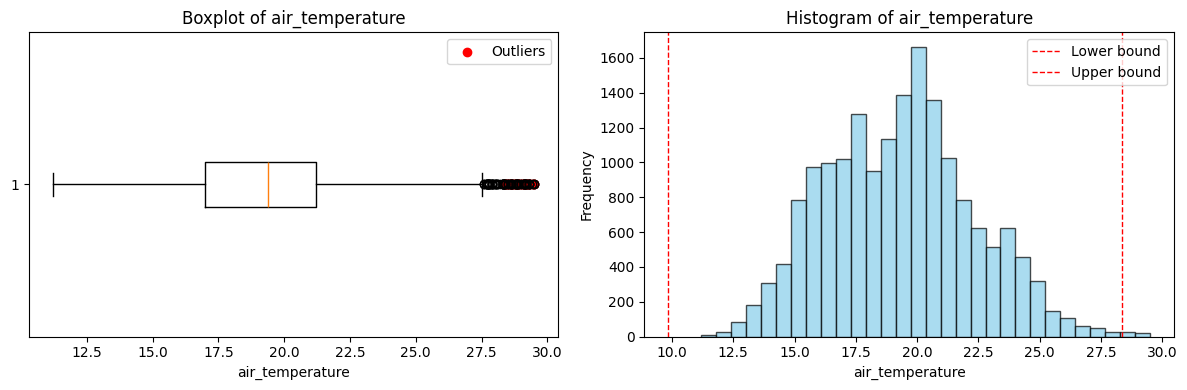

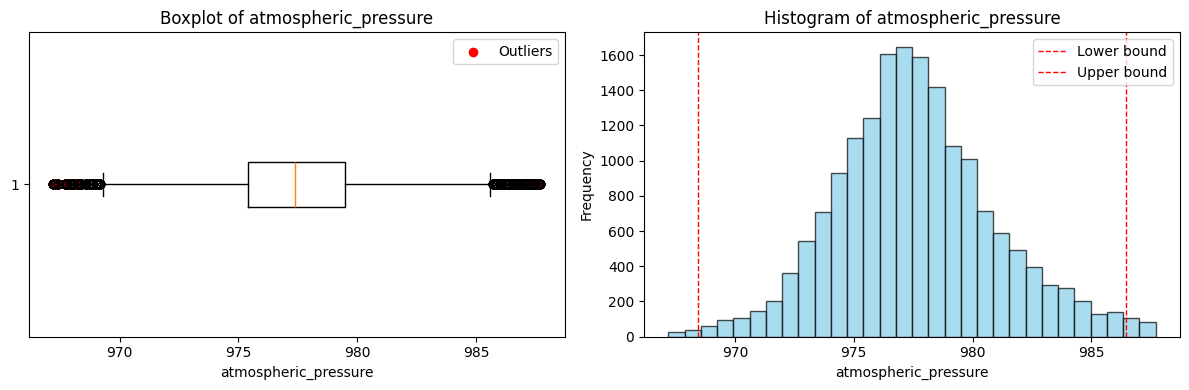

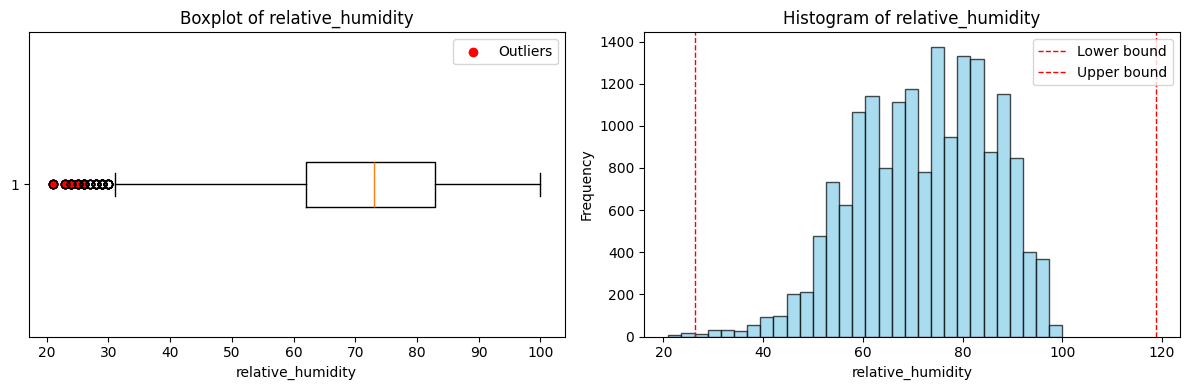

  air_temperature outlier row indices: [Timestamp('2023-08-20 13:00:00+0000', tz='UTC'), Timestamp('2023-08-20 14:00:00+0000', tz='UTC'), Timestamp('2023-08-22 13:00:00+0000', tz='UTC'), Timestamp('2023-08-22 14:00:00+0000', tz='UTC'), Timestamp('2023-08-22 15:00:00+0000', tz='UTC'), Timestamp('2023-08-22 16:00:00+0000', tz='UTC'), Timestamp('2023-08-25 13:00:00+0000', tz='UTC'), Timestamp('2023-08-26 16:00:00+0000', tz='UTC'), Timestamp('2023-08-26 17:00:00+0000', tz='UTC'), Timestamp('2023-10-06 12:00:00+0000', tz='UTC'), Timestamp('2023-10-06 17:00:00+0000', tz='UTC'), Timestamp('2023-10-07 11:00:00+0000', tz='UTC'), Timestamp('2023-10-07 17:00:00+0000', tz='UTC'), Timestamp('2023-10-07 18:00:00+0000', tz='UTC'), Timestamp('2023-10-08 11:00:00+0000', tz='UTC'), Timestamp('2023-10-08 12:00:00+0000', tz='UTC'), Timestamp('2023-10-08 14:00:00+0000', tz='UTC'), Timestamp('2023-10-08 15:00:00+0000', tz='UTC'), Timestamp('2023-10-08 16:00:00+0000', tz='UTC'), Timestamp('2023-10-09 12:00:0

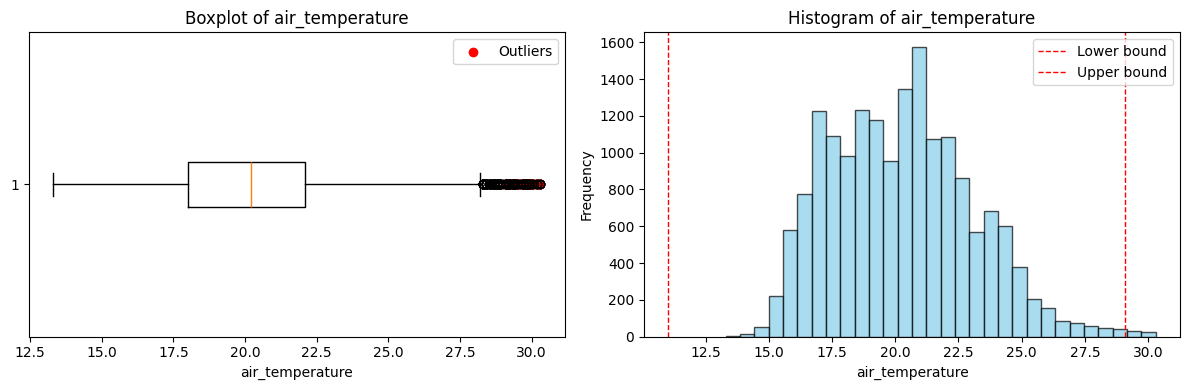

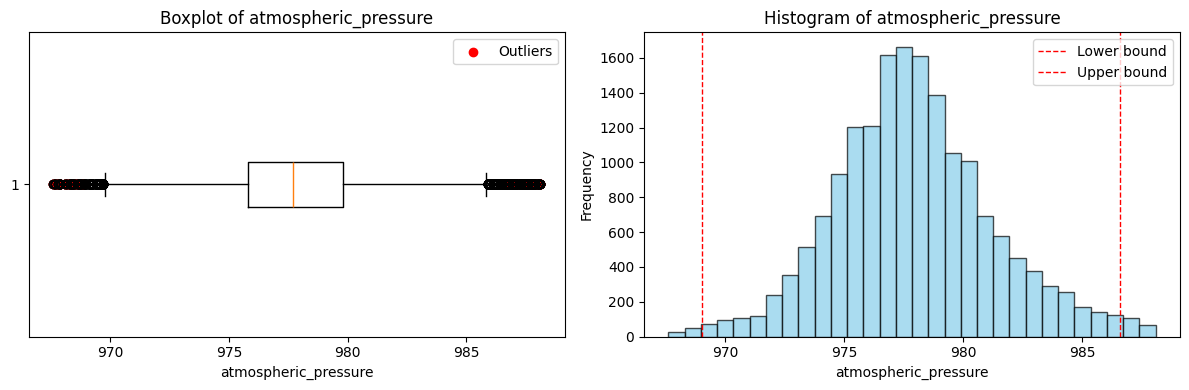

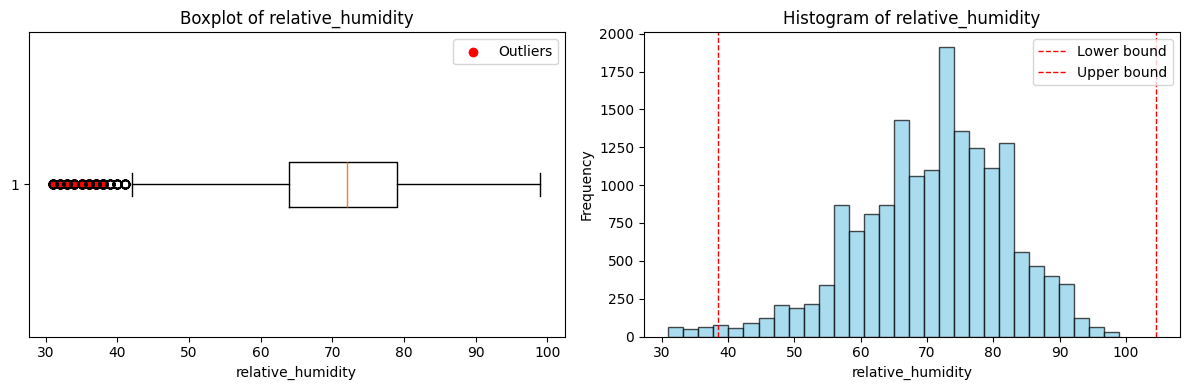

  air_temperature outlier row indices: [Timestamp('2023-06-27 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 12:00:00+0000', tz='UTC'), Timestamp('2023-06-28 13:00:00+0000', tz='UTC'), Timestamp('2023-06-28 14:00:00+0000', tz='UTC'), Timestamp('2023-06-28 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 16:00:00+0000', tz='UTC'), Timestamp('2023-06-29 12:00:00+0000', tz='UTC'), Timestamp('2023-06-29 13:00:00+0000', tz='UTC'), Timestamp('2023-06-29 15:00:00+0000', tz='UTC'), Timestamp('2023-06-29 16:00:00+0000', tz='UTC'), Timestamp('2023-07-13 11:00:00+0000', tz='UTC'), Timestamp('2023-07-13 18:00:00+0000', tz='UTC'), Timestamp('2023-07-14 13:00:00+0000', tz='UTC'), Timestamp('2023-07-14 14:00:00+0000', tz='UTC'), Timestamp('2023-07-14 15:00:00+0000', tz='UTC'), Timestamp('2023-07-14 16:00:00+0000', tz='UTC'), Timestamp('2023-08-11 11:00:00+0000', tz='UTC'), Timestamp('2023-08-12 10:00:00+0000', tz='UTC'), Timestamp('2023-08-12 18:00:00+0000', tz='UTC'), Timestamp('2023-08-13 11:00:0

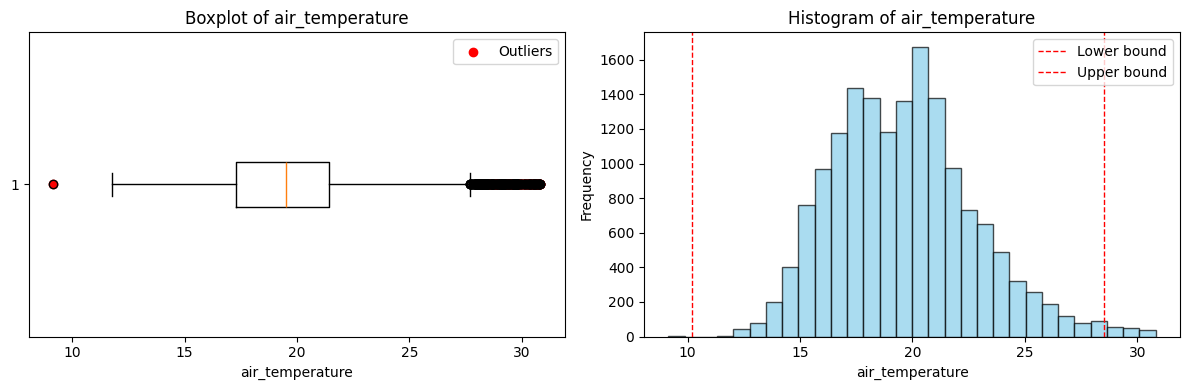

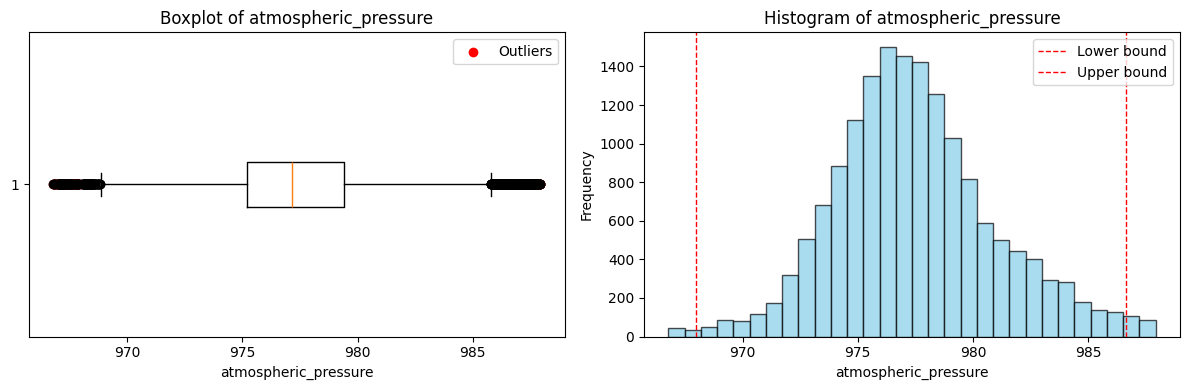

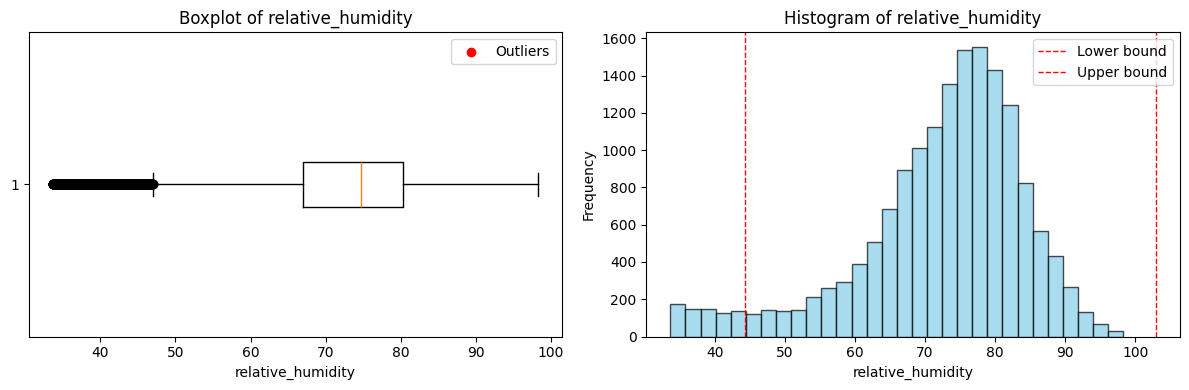

  air_temperature outlier row indices: [Timestamp('2023-06-28 09:00:00+0000', tz='UTC'), Timestamp('2023-06-28 11:00:00+0000', tz='UTC'), Timestamp('2023-07-11 13:00:00+0000', tz='UTC'), Timestamp('2023-07-11 14:00:00+0000', tz='UTC'), Timestamp('2023-07-11 15:00:00+0000', tz='UTC'), Timestamp('2023-07-12 10:00:00+0000', tz='UTC'), Timestamp('2023-07-12 11:00:00+0000', tz='UTC'), Timestamp('2023-07-12 12:00:00+0000', tz='UTC'), Timestamp('2023-07-12 13:00:00+0000', tz='UTC'), Timestamp('2023-07-12 14:00:00+0000', tz='UTC'), Timestamp('2023-07-12 15:00:00+0000', tz='UTC'), Timestamp('2023-07-12 18:00:00+0000', tz='UTC'), Timestamp('2023-07-31 15:00:00+0000', tz='UTC'), Timestamp('2023-07-31 16:00:00+0000', tz='UTC'), Timestamp('2023-08-10 09:00:00+0000', tz='UTC'), Timestamp('2023-08-10 10:00:00+0000', tz='UTC'), Timestamp('2023-08-10 13:00:00+0000', tz='UTC'), Timestamp('2023-08-10 14:00:00+0000', tz='UTC'), Timestamp('2023-08-10 17:00:00+0000', tz='UTC'), Timestamp('2023-08-11 06:00:0

In [99]:
threshold = 1.7

for file_key, df_hourly in dataframes.items():
    print(f"Processing {file_key}:")
    
    # Use the modified function to get both outlier values and their indices
    outliers, outlier_indices = detect_outliers_iqr(df_hourly, threshold, return_indices=True)
    
    # Print outliers for each column
    for column, indices in outlier_indices.items():
        print(f"  {column} outlier row indices: {indices}")
    
    # Combine all outlier indices from every column
    all_outlier_indices = set()
    for indices in outlier_indices.values():
        all_outlier_indices.update(indices)
    
    # Remove rows with any detected outlier
    df_clean = df_hourly.drop(list(all_outlier_indices))
    dataframes[file_key] = df_clean
    
    print(f"Removed {len(all_outlier_indices)} rows with outliers from {file_key}.\n")

## Escritura fichero 

In [98]:
for file_key, df_hourly in dataframes.items():
  print(df_hourly.describe())

       air_temperature  atmospheric_pressure  relative_humidity
count     17359.000000          17359.000000       17359.000000
mean         19.292517            977.578224          72.302610
std           3.021339              3.366259          13.445633
min          11.200000            967.200000          21.000000
25%          17.000000            975.400000          62.000000
50%          19.400000            977.400000          73.000000
75%          21.200000            979.500000          83.000000
max          29.500000            987.700000         100.000000
       air_temperature  atmospheric_pressure  relative_humidity
count     17212.000000          17212.000000       17212.000000
mean         20.247461            977.912329          70.768766
std           2.805553              3.345336          11.356939
min          13.300000            967.600000          31.000000
25%          18.000000            975.800000          64.000000
50%          20.200000            977.70